In [39]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pylab
import time 
import pandas as pd
from random import randrange
import statistics
from scipy.interpolate import UnivariateSpline

class grid:

    def __init__(self, x, y, params):
        #x = grid x
        #y = grid y
        #params number of facies

        self.x = x
        self.y = y
        self.params = params
        self.array = []
        self.cmap = []
        self.norm = []
        img = []

    def update(self):
        return plt.imshow(self.array,interpolation='nearest',
                                cmap = self.cmap,norm=self.norm
                                )


    def genrandomgrid(self):
            self.array = np.random.randint(self.params, size=(self.x, self.y))

    def show2dgrid(self):
        global img
        bounds=[]

        for i in range (0,self.params+2):
            bounds.append(i)


        self.cmap = plt.cm.tab10  # define the colormap replace if needed
        # extract all colors from the .jet map
        cmaplist = [self.cmap(i) for i in range(self.cmap.N)]

        # create the new map
        self.cmap = mpl.colors.LinearSegmentedColormap.from_list(
            'Custom cmap', cmaplist, self.cmap.N)

        self.norm = mpl.colors.BoundaryNorm(bounds, self.cmap.N)


        # tell imshow about color map so that only set colors are used
        img = self.update()

        cmapbounds = bounds
        del cmapbounds[-1]
        #define ticks
        cblegend = cmapbounds

        #define colour bar remove blink colour
        cb = plt.colorbar(img,boundaries=cmapbounds,ticks=cblegend)
        labels = np.arange(0, int(cblegend[-1]), 1)
        loc = labels + .5
        cb.set_ticklabels(labels)
        cb.set_ticks(loc)
        cb.ax.tick_params(width=0)
        cb.set_label('Facies Value', rotation=90)
        self.update()
        return plt.show(block=False)

    def gridblink(self, x, y):
        global img
        reset = self.array[x, y]
        self.array[x, y] = self.params+1 #blinks with next colour
        self.update()
        time.sleep(1)
        self.array[x, y] = reset #blinks with next colour
        self.update()

    def randomreturn(self, n, iterations, valuemode):
        #arraystructure = [[x1,y1,v1],[x2,y2,v2]]

        cords = self.array
        shape = list(cords.shape)
        self.randarry = []
        self.graphdata = []
        data = []

        for i in range(0,iterations):
            randomseq = []
            for i in range(n):
                x = randrange(shape[1])
                y = randrange(shape[0])
                if valuemode == True:
                    randomseq.append([self.array[x,y]]) 
                    #only returns grid values and not x,y
                else:
                    randomseq.append(x,y,self.array[x,y]) 
                    #returns coords and value in array
            data.append(randomseq)
        self.graphdata = data
        return self.graphdata

    def mean(self): #returns mean value of array
        self.mean = np.mean(self.array)
        return self.mean

    def plot(self, type):
        #variables
        iterations = len(self.graphdata[0])
        numruns = len(self.graphdata)
        #creates moving adverages of data
        def movavg():
            def mov_avg(x, w):
                for m in range(len(x)-(w-1)):
                    yield sum(np.ones(w) * x[m:m+w]) / w 

            rawdata = self.graphdata

            data = {'y':[]}#dataframe
            df = pd.DataFrame(data)
            #df = df.transpose()

            x = []
            for n in range(0,iterations):
                x.append(n+1)

            df['iteration'] = x #x value for graph

            for run in range(0,numruns):
                y = [val for sublist in self.graphdata[run] for val in sublist]
                df['y'] = y
                df['SMA' + str(run)] = df.y.rolling(iterations, min_periods=1).mean()
            del df['y']
            return df

        df = movavg()

        #sphaghetti plot
        def sphagetti():

            #plot moving avergdge data from dataframe
            for run in range(0,numruns):
                plt.plot(df['iteration'],df['SMA' + str(run)])

            plt.xlim([1,iterations])
            plt.ylim([0,self.params-1])
            plt.xlabel('Iterations')
            plt.ylabel('Measured value')


            print('Input parameters:')
            print('Iterations:', iterations)
            print('Number of sample runs:', numruns)
            print('Mean value:', self.mean())

            return plt.show(block=False)

        #minmax plot
        def minmax():

            
            def max(df):
                x = df['iteration']
                del df['iteration']
                df['Max'] = df.max(axis=1)
                df['iteration'] = x

            def min(df):
                x = df['iteration']
                del df['iteration']
                df['Min'] = df.min(axis=1)
                df['iteration'] = x

            x = df['iteration']

            max(df)
            min(df)

            max1 = df['Max']
            min1 = df['Min']

            ymax = max1.values.tolist()
            ymin = min1.values.tolist()

            #curve is y = 1/x
            smax = UnivariateSpline(x, ymax, k=5, s=iterations)
            xsmax = np.linspace(0, iterations , 100)
            ysmax = smax(xsmax)

            smin = UnivariateSpline(x, ymin, k=5, s=iterations)
            xsmin = np.linspace(0, iterations , 100)
            ysmin = smin(xsmin)

            #plt.plot(xsmax, ysmax,color='red')
            #plt.plot(xsmin, ysmin,color='blue')
            
            plt.plot(x, max1, 'r+', alpha=0.3)
            plt.plot(x, min1, 'b+', alpha=0.3)


            mean = self.mean #call mean
            plt.axhline(mean, color='r', linestyle=':')#mean line
            plt.figtext(1, 0, mean, wrap=True, horizontalalignment='right', fontsize=12)#mean text
            plt.xlim([1,iterations])
            plt.ylim([0,self.params-1])
            plt.xlabel('Iterations')
            plt.ylabel('Measured value')
            
            return plt.show(block=False), df




        if type == 'sphagetti':
            return sphagetti()
        elif type == 'minmax': #sphagetti must be plotted before minmax
            return minmax()
        else:
            return ('Error: no valid type selected')

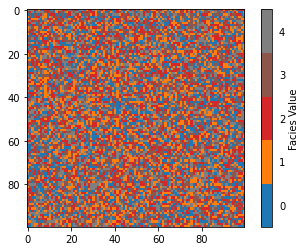

Input parameters:
Iterations: 10
Number of sample runs: 20
Mean value: 1.9992


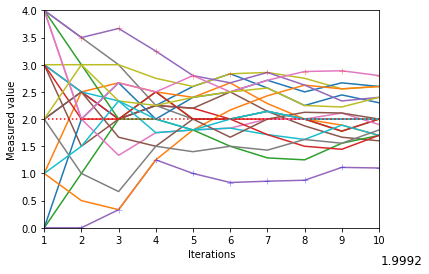

(None,
        SMA0      SMA1      SMA2      SMA3      SMA4      SMA5      SMA6  \
 0  2.000000  1.000000  0.000000  3.000000  0.000000  3.000000  4.000000   
 1  2.500000  2.500000  1.000000  2.500000  0.000000  1.500000  2.000000   
 2  2.000000  2.666667  2.000000  2.000000  0.333333  2.000000  1.333333   
 3  2.250000  2.500000  2.500000  2.250000  1.250000  2.250000  1.750000   
 4  2.600000  2.400000  2.000000  2.200000  1.000000  2.200000  1.800000   
 5  2.833333  2.666667  2.000000  2.000000  0.833333  2.500000  1.833333   
 6  2.571429  2.285714  2.142857  2.000000  0.857143  2.142857  2.000000   
 7  2.250000  2.000000  2.000000  2.000000  0.875000  1.875000  2.000000   
 8  2.444444  1.888889  1.777778  1.777778  1.111111  1.666667  2.111111   
 9  2.300000  1.700000  2.000000  2.000000  1.100000  1.600000  1.900000   
 
        SMA7      SMA8      SMA9  ...     SMA13     SMA14     SMA15     SMA16  \
 0  4.000000  3.000000  3.000000  ...  3.000000  4.000000  2.000000  4.000

In [40]:
gridx = 100
gridy = 100
facies  = 5

runs = 20
iterations = 10 #iterations is x axis param

#creates grid of dimension x,y, number of facies
data = grid(gridx,gridy,facies)
data.genrandomgrid()
data.show2dgrid()

#returns randomly extracted data
#randomreturn(n, iterations, valuemode)
data.randomreturn(iterations, runs, True)

#plots data on graph
#plot()
data.plot('sphagetti')
data.plot('minmax')




